In [1]:
import panel as pn                                      #library for panels
pn.extension('plotly')
import plotly.express as px
import pandas as pd                                     #panda library
import matplotlib.pyplot as plt
import os                                               #os interface library 
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api

import alpaca_trade_api as trade_api                    #Alpaca library
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
from datetime import date                               #Data-Time library
from ipywidgets import *                                #Interactive Widgets library
import yfinance as yf
import numpy as np

from bokeh.settings import settings
settings.resources = 'cdn'
settings.resources = 'inline'



Bad key savefig.frameon in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [11]:
#Set up the alpaca trading API to retrieve data
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")                                    #Set the Alpaca Key
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")                              #Set the Alpaca secret key
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')  #Set the REST api with URL and keys
    return alpaca                                                                 #Return the Alpaca API object


#Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                                #Set Start date 5 years back from now                    
    today = pd.Timestamp(today, tz="America/New_York").isoformat()                #convert to ISO datetime format
    timeframe ='1Day'                                                             #Set to retrive day trade data
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df #Get the trading info based on the ticker
    portfolio.index = portfolio.index.date                                        #Set index key to date column 
    return portfolio                                                              #Return the extracted value


#function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)                                           #Get benchmark data from Alpaca API for giventicker
    symbol = bench_mark[['close']].rename(columns = {'close': symbol})            #Rename column from 'close' to ticker name
    return symbol                                                                 #Return the extracted value

#function to calculate rick for portfolio :
def riskf_r():
    today = date.today() + pd.DateOffset(years=-5)
    rf_rate = yf.download('^IRX',start = today)
    rf_rate = rf_rate[['Close']]
    rf_rate = rf_rate.rename(columns = {'Close' : 'rf_rate'})
    rf_returns = rf_rate.pct_change()
    rf_returns = rf_returns.dropna()
    return rf_returns


#function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)         #Extract ticker based on given symbol value
    closing_price = ticker[['close']]                                             #Extract close price only for that ticker
    closing_price = closing_price.rename(columns={'close' : symbol})              #Rename the column to "close"
    return closing_price                                                          #Return the extracted value


#function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()                                             #Calculate % change for given df - data
    data_cumulative = (1 + data_returns).cumprod()                               #compute the cumulative product on %change
    return data_cumulative                                                       #Return the extracted value

# function for equally weghting stocks:
def equal_weights(data):
    weights = []                                                                 #Set list variable -> weights
    for i in range(0, len(data.columns)):                                        #Cal weights for each element in -> data
        w = 1 / len(data.columns)
        weights.append(w)                                                        #Append calculated value to weights list
    return weights                                                               #Return the composed list

# function for varrying weights:
def combination_weights(data,initial_investment):
    from itertools import combinations
    import numpy as np
    df = []
    a = list(np.arange(0.05,1,0.01))
    random_set = [round(i,3) for i in a]
    
    comb = combinations(random_set,len(data.columns))
    possible_combinations = []
    # for loop for appropriate weights :
    for i in comb:
        if sum(i) == 1:
            possible_combinations.append(i)
    daily_returns = data.pct_change().dropna()
    for i in possible_combinations:
        possible_returns = daily_returns.dot(i)
        cumulative_final_return = (1+possible_returns).cumprod()
        final_day_value = cumulative_final_return.iloc[-1]
        final_return = final_day_value*initial_investment
        df.append((final_return,i))
    data_frame = pd.DataFrame(df)
    best_combination = data_frame.rename(columns={0:'Return',1:'Weights'})
    top_5 = best_combination.nlargest(5,'Return')    
    return top_5

# function for sharpe ratios :
def sharpe_ratios(a):
    best_weights = a['Weights']
    cumulative_weighted_portfolios = []
    for i in best_weights:
        weighted_price_action = portfolio_cumulative.dot(i)
        cumulative_weighted_portfolios.append(weighted_price_action)
        c_w_p = pd.DataFrame(cumulative_weighted_portfolios)
    c_w_p = c_w_p.T
    c_w_p = c_w_p.rename(columns ={0 :'w1',1:'w2',2:'w3',3:'w4',4:'w5'})
    c_w_returns = c_w_p.pct_change()
    c_w_r =c_w_returns.dropna()
    assembled_returns = pd.concat([c_w_r,r_rate],axis =1 ,join ='inner')
    s_r = ((assembled_returns.mean()-assembled_returns['rf_rate'].mean())*252)/(assembled_returns.std()*np.sqrt(252))
    sharpe_ratio = pd.Series(s_r)
    sharpe_ratio = sharpe_ratio.drop('rf_rate')
    a['sharpe_ratio'] = sharpe_ratio.values
    return a

def benchmark_comaprison(b):
    spy_returns = spy.pct_change()
    spy_returns = spy_returns.dropna()
    spy_final_value = spy_cumulative*1000
    spy_final_value=list(spy_final_value.iloc[-1])
    spy_sharpe = pd.concat([spy_returns,r_rate],axis = 1,join ='inner')
    spy_sharpe_ratio = ((spy_sharpe.mean()-spy_sharpe['rf_rate'].mean()))*252/(spy_sharpe.std()*np.sqrt(252))
    spy_sharpe_ratio =pd.Series(spy_sharpe_ratio)
    spy_sharpe_ratio = spy_sharpe_ratio['SPY']
    sharpe_ratio.loc['SPY'] = [spy_final_value[0],((1)),spy_sharpe_ratio]
    percent_return = []
    for i in sharpe_ratio['Return']:
        initial_investment = 1000
        per_return = ((i - initial_investment)/initial_investment)*100
        percent_return.append(per_return)
    sharpe_ratio['%_return'] = percent_return
    return sharpe_ratio


#Run the MC Simulation
def MC_simulation(Years):
    global simulation_ew                                                        #Set global variable
    text = ""
    if Years > 0:
        simulation_ew = MCSimulation(                                           #run the MC simulation
                MC_data,
                weights=equal_weights(MC_data),
                num_simulation=1000,
                num_trading_days=252*Years)
        simulation_ew.calc_cumulative_return()                                  #Calculate the cumulative return
        summary_stats = simulation_ew.summarize_cumulative_return()             #summary statistics from the MC simulation results
        volatility = round(summary_stats[2] * np.sqrt(252) )                    #Calculate the volatility       
        text = f"<b>Volatility based on this configuration is {text}</b>"       #Form the volatility information
        display(HTML(text))                                                     #Display the volatility
        display(simulation_ew.simulated_return)                                 #Display each cumulative return
        display(simulation_ew.plot_simulation())                                #Plot the simulation


        
#calculating confidenace level based on MC simulation
def confidence_level(Investment):
    """
    MC Simulation must be ran before executing this function
    """
    #global summary_stats
    Investment = Investment.replace('$','')                                     #Remove $
    Investment = Investment.replace(',','')                                     #Remove ','
    Investment = int(Investment)                                                #Convert the value to int
    summary_stats = simulation_ew.summarize_cumulative_return()                 # summary statistics from the MC simulation results
    initial_investment = Investment                                             # Set initial investment

    # Using lower & upper CI to calculate the `95%` confidence level for chosen investment
    ci_lower = round(summary_stats[8] * initial_investment, 2)
    ci_upper = round(summary_stats[9] * initial_investment, 2)

    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
          f" over a year will end within in the range of"
          f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")

    
#Rename column to close since Mc requires column name "close"    
def condition_data():
    global MC_data, portfolio_joint
    #Extract and format each ticker from df-> Portfolio
    apd =format_data('APD')
    flex =format_data('FLEX')
    ppg=format_data('PPG')
    tel=format_data('TEL')
    iff=format_data('IFF')
    glw=format_data('GLW')

    apd1 = apd.rename(columns={'APD' : 'close'})
    flex1 = flex.rename(columns={'FLEX' : 'close'})
    ppg1 = ppg.rename(columns={'PPG' : 'close'})
    tel1 = tel.rename(columns={'TEL' : 'close'})
    iff1 = iff.rename(columns={'IFF' : 'close'})
    glw1 = glw.rename(columns={'GLW' : 'close'})
    MC_data = pd.concat([apd1, flex1, ppg1, tel1, iff1, glw1],
                         axis = 1, keys = ['APD', 'FLEX', 'PPG', 'TEL', 'IFF', 'GLW']
                        )
    #Concatinate all the tickers into one dataframe
    portfolio_joint = pd.concat([apd, flex, ppg, tel, iff, glw],axis =1)

#Ploting graph
def create_line_chart1(data, title, xlabel, ylabel):     
    fig = plt.figure(figsize=(6, 5))
    bar_chart = data.plot.line()
    bar_chart.set_xlabel(xlabel, fontsize=12)
    bar_chart.set_ylabel(ylabel, fontsize=12)
    bar_chart.set_title(title, fontsize=14, fontweight="bold")
    plt.close(fig)
    
    return pn.pane.Matplotlib(fig, tight=True)

In [12]:
alpaca = setting_api()                                    #Set the Alpaca API
tickers = ['APD', 'FLEX', 'PPG', 'TEL', 'IFF', 'GLW']     #Set tickers
portfolio = portfolio_data(tickers)                       #Rtv ticker values using Alpca API
condition_data()                                          #Condition data and dataframe to be used here
portfolio.head()                                          #Show the retrieved value

open      high     low   close   volume  trade_count  \
2017-04-19  135.73  136.0399  134.78  134.96   577819         7170   
2017-04-20  135.62  137.3400  135.20  136.90   985329        10779   
2017-04-21  136.87  137.6600  136.82  137.30  1121329         9645   
2017-04-24  138.79  139.9000  137.91  139.76  1006799        11797   
2017-04-25  140.22  141.8600  140.14  141.73  1189378        12897   

                  vwap symbol  
2017-04-19  135.166924    APD  
2017-04-20  136.676759    APD  
2017-04-21  137.275887    APD  
2017-04-24  139.453526    APD  
2017-04-25  141.327276    APD

In [13]:
spy = bench_mark('SPY')     #Get the benchmark ticker - S&P 500
spy.head()                  #View the retrieved dataframe

SPY
2017-04-19  233.44
2017-04-20  235.34
2017-04-21  234.59
2017-04-24  237.17
2017-04-25  238.55

In [14]:
#Calculate cumulative portfolio
portfolio_cumulative = cumulative_returns(portfolio_joint)             #Calculate cumulative returns for stock portfolio
portfolio_cumulative.dropna(inplace=True) 

<AxesSubplot:xlabel='Years', ylabel='Weighted Value'>

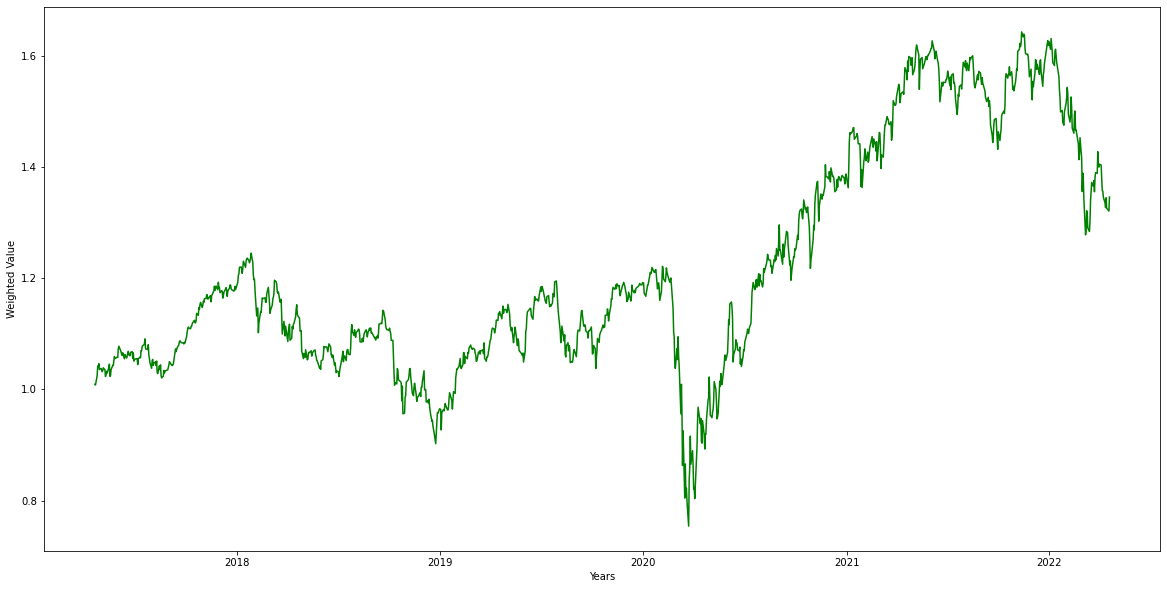

In [15]:
weights = equal_weights(portfolio_joint)                          #Calculate the equal weighted value for each ticker
portfolio_price_action = portfolio_cumulative.dot(weights)        #Get the cumulative product by weights for each tickers

#Plot line graph
portfolio_price_action.plot(figsize = (20,10), kind="line", ylabel='Weighted Value', xlabel='Years', color='g')  


In [16]:
spy_cumulative = cumulative_returns(spy)                                                             #Get cumulative return ffor benchmark
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()    #Concat both df
comparison = comparison.rename(columns = {0:'E.W Portfolio'})                                        #Give a column name
comparison

E.W Portfolio       SPY
2017-04-20       1.009523  1.008139
2017-04-21       1.008011  1.004926
2017-04-24       1.024802  1.015978
2017-04-25       1.041892  1.021890
2017-04-26       1.040289  1.021247
...                   ...       ...
2022-04-12       1.327105  1.877527
2022-04-13       1.344797  1.899032
2022-04-14       1.326094  1.875386
2022-04-18       1.320887  1.876157
2022-04-19       1.346087  1.906443

[1259 rows x 2 columns]

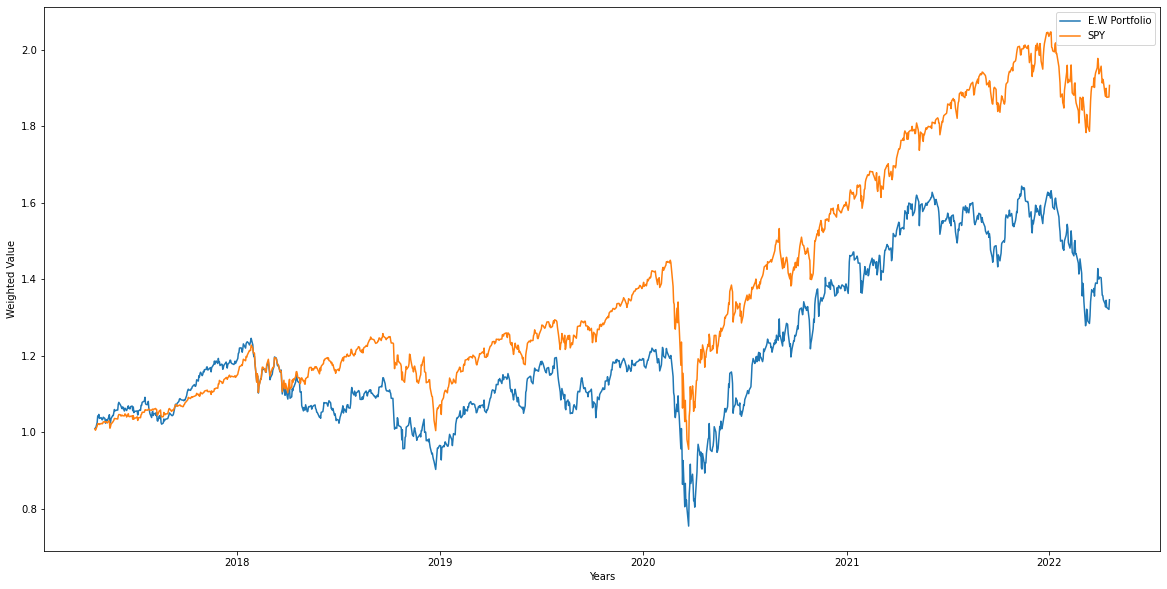

In [17]:
#Plot the comparison data
#def com():
spy_cumulative = cumulative_returns(spy)                                                             #Get cumulative return ffor benchmark
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()    #Concat both df
comparison = comparison.rename(columns = {0:'E.W Portfolio'})   
    
comparison1 = comparison.plot(figsize = (20,10), kind="line", ylabel='Weighted Value', xlabel='Years')
#    return comparison

In [18]:
r_rate = riskf_r()              

[*********************100%***********************]  1 of 1 completed


In [19]:
top_returns = combination_weights(portfolio,initial_investment=1000)

KeyboardInterrupt: 

In [19]:
top_returns

NameError: name 'top_returns' is not defined

In [20]:
sharpe_ratio = sharpe_ratios(top_returns)

NameError: name 'top_returns' is not defined

In [12]:
#create_line_chart1(portfolio_cumulative, title='Cumulative Comparion', xlabel='Years', ylabel='Cumulative Value')
#create_bar_chart(comparison, title='Comparion Chart', xlabel='Years', ylabel='Weighted Value')

Column(height=768, sizing_mode='fixed', width=1024)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str, width=800)
        [1] Column
            [0] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
        [2] Column(height=1000, sizing_mode='fixed', width=1200)
            [0] Markdown(str)
            [1] IPyWidget(interactive)
        [3] Row
            [0] Column(height=1200, sizing_mode='fixed', width=1200)
                [0] Markdown(str)
                [1] IPyWidget(interactive)
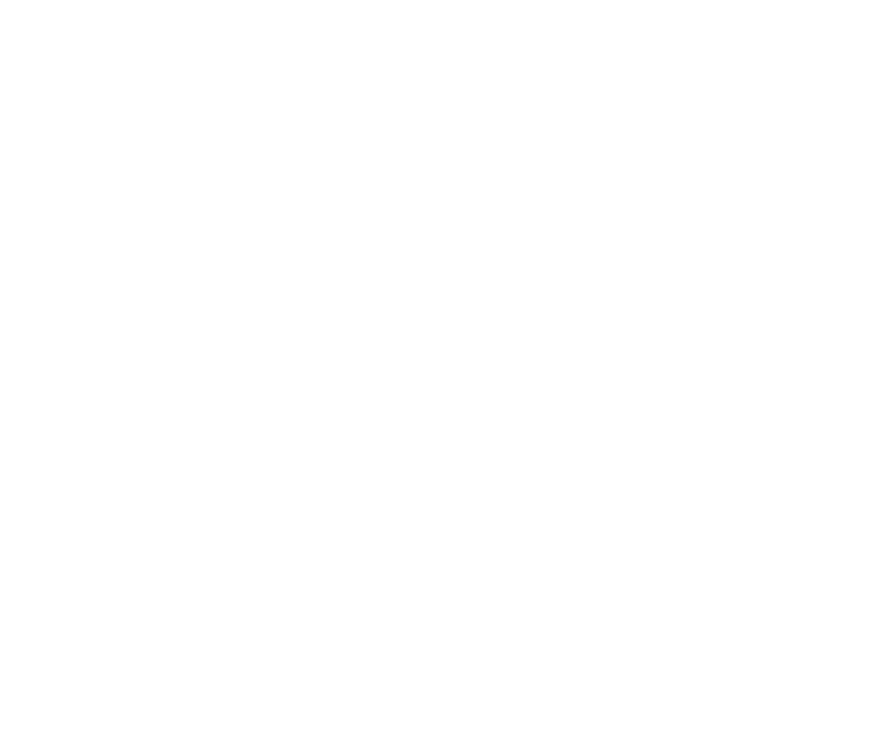
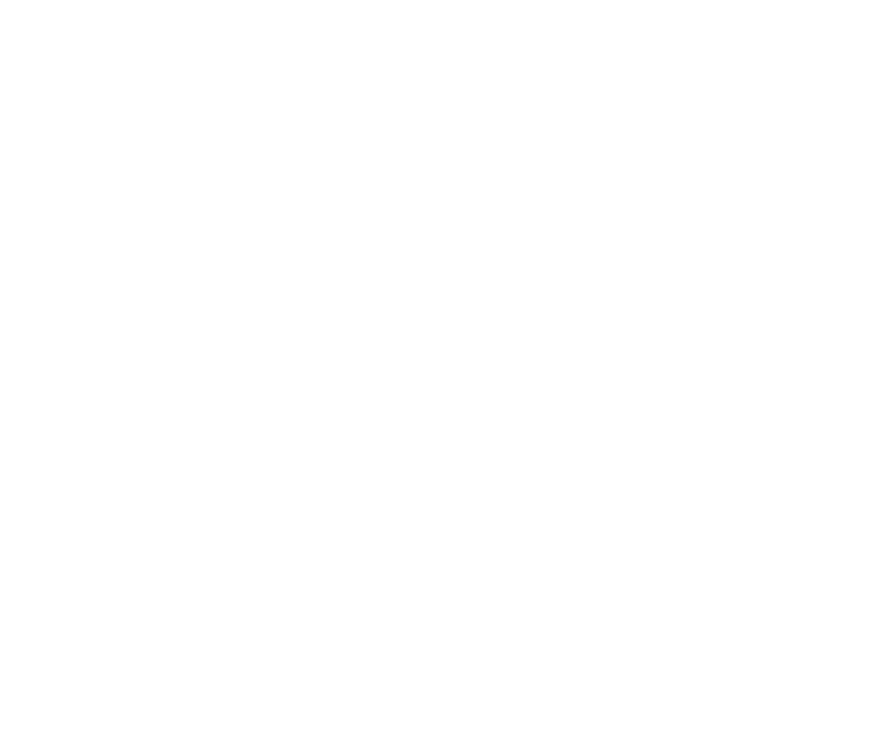

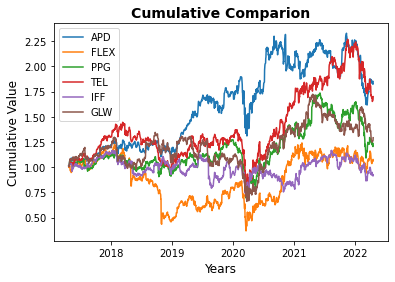

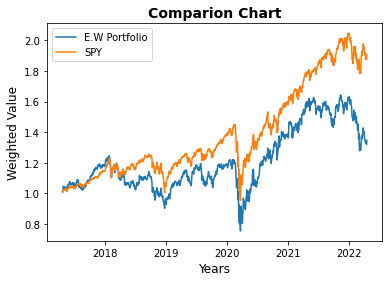

In [21]:
title = pn.pane.Markdown(""" 
        ### Responsible Investor """,  
        width=800)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    # First tab
    (
        "Welcome",
        pn.Column(
            title,
        )
    ),
    
    # Second tab
    (
        "Graph",
        pn.Column(
                pn.Row(
                    create_line_chart1(
                        portfolio_cumulative, 
                        title='Cumulative Comparion', 
                        xlabel='Years', 
                        ylabel='Cumulative Value'
                        ),
                    create_line_chart1(
                        comparison, 
                        title='Comparion Chart', 
                        xlabel='Years', 
                        ylabel='Weighted Value'
                        ),
                    )
                )
    ),

     # Third tab
     (
         "Monte Carlo simulation",
         pn.Column(
             "Choose your trading years", interactive(MC_simulation, Years=([1, 3, 5]), value=None),
             height=1000, width=1200
                 ),
     ),
    
     # Forth Tab
     (
         "Confidence level",
         pn.Row(
             pn.Column(
                 "Choose your initial investment amount",
                 interactive(confidence_level, Investment=['$5,000', '$10,000', '$15,000'], value=None),
                 height=1200, width=1200
                      ),
         )
     ),

 )


# Create the main dashboard
dashboard = pn.Column(
     pn.Row(title),
     tabs,
     width=1024,
     height=768
 )

#dashboard
dashboard.servable()